In [1]:
!pip install torch==2.2.1 torchvision==0.17.1 torchaudio==2.2.1 --index-url https://download.pytorch.org/whl/cu121
!pip install transformers
!pip install timm
!pip install packaging
!pip install wheel
!pip install ninja
!pip install flash_attn  # not on windows
# Download wheel file from : https://github.com/bdashore3/flash-attention/releases
!pip install flash_attn-2.5.9.post1+cu122torch2.2.2cxx11abiFALSE-cp311-cp311-win_amd64.whl
!pip install einops
!pip install accelerate
!pip install peft
!pip install matplotlib

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.3/757.3 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

#import Libraries

In [1]:
from transformers import AutoModelForCausalLM
import io
import os
import re
import json
import torch
import html
import base64
import itertools
import numpy as np
from IPython.core.display import display, HTML
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Generator
from peft import LoraConfig, get_peft_model
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont

In [2]:
from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Florence 2 Model
model_id = 'microsoft/Florence-2-large'
#model_id = 'microsoft/Florence-2-base'

# Load model onto the determined device
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).to(DEVICE)

processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


#Custom Training

In [5]:
class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self) -> list:
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> tuple:
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        try:
            image = Image.open(image_path)
            image = image.resize((256, 256))  # Resize image to 256x256
            return (image, entry)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")


class DetectionDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = data['prefix']
        suffix = data['suffix']
        return prefix, suffix, image

In [15]:
# Initiate DetectionsDataset and DataLoader for train and validation subsets
BATCH_SIZE = 1
NUM_WORKERS = 0

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
    return inputs, answers

train_dataset = DetectionDataset(
    jsonl_file_path = "/content/Florence-2/train/train_annotations.json",
    image_directory_path = "/content/Florence-2/train"
)
val_dataset = DetectionDataset(
    jsonl_file_path = "/content/Florence-2/valid/valid_annotations.json",
    image_directory_path = "/content/Florence-2/valid"
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)

In [8]:
# Setup LoRA Florence-2 model
config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head", "fc2"],
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
)

peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()

trainable params: 4,133,576 || all params: 826,827,464 || trainable%: 0.4999


In [9]:
torch.cuda.empty_cache()

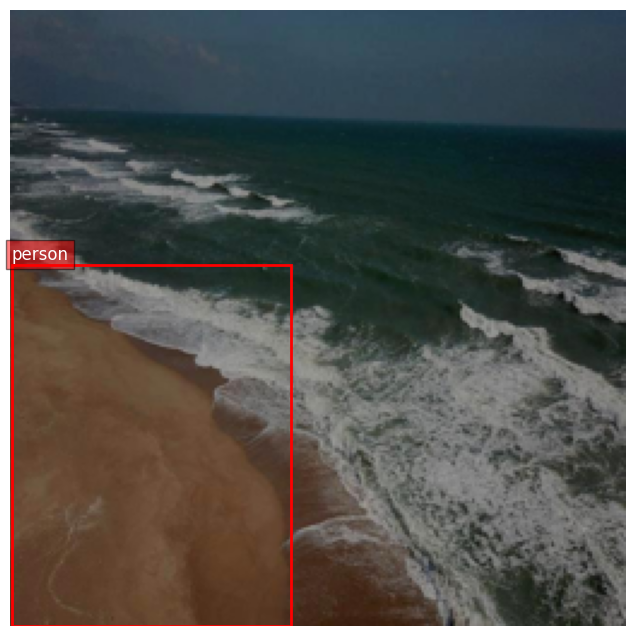

{'<OD>': {'bboxes': [[0.12800000607967377,
    105.34400177001953,
    116.35200500488281,
    255.6160125732422]],
  'labels': ['person']}}

In [10]:
import matplotlib.pyplot as plt
def plot_bboxes_on_image(image, bboxes, labels):
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    ax = plt.gca()
    for bbox, label in zip(bboxes, labels):
        xmin, ymin, xmax, ymax = bbox
        width = xmax - xmin
        height = ymax - ymin
        rect = plt.Rectangle((xmin, ymin), width, height, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin, ymin - 2, label, bbox=dict(facecolor='red', alpha=0.5), fontsize=12, color='white')

    plt.axis('off')
    plt.show()
def florence2_inference_results(model, dataset: DetectionDataset, count: int):
    count = min(count, len(dataset))
    for i in range(count):
        image, data = dataset.dataset[i]
        prefix = data['prefix']
        suffix = data['suffix']
        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
        #inputs = processor(text=prompt, images=image, return_tensors="pt")
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            early_stopping=False,
            do_sample=False,
            num_beams=3,
        )
        generated_text = processor.batch_decode(generated_ids,
                                                skip_special_tokens=False)[0]
        parsed_answer = processor.post_process_generation(
            generated_text,
            task='<OD>',
            image_size=(image.width, image.height))
        # Access bounding boxes and labels
        od_results = parsed_answer['<OD>']
        bboxes = od_results['bboxes']
        labels = od_results['labels']

        # Plot bounding boxes on the image using the separate function
        plot_bboxes_on_image(image, bboxes, labels)
    return parsed_answer


florence2_inference_results(peft_model, val_dataset, 1)

In [13]:
# training loop
from torch.cuda.amp import GradScaler, autocast
def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    scaler = GradScaler()  # Mixed precision training

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False
            ).input_ids.to(DEVICE)

            optimizer.zero_grad()
            with autocast():
                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            lr_scheduler.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(
                    text=answers,
                    return_tensors="pt",
                    padding=True,
                    return_token_type_ids=False
                ).input_ids.to(DEVICE)

                with autocast():
                    outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                    loss = outputs.loss

                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Average Validation Loss: {avg_val_loss}")

            florence2_inference_results(peft_model, val_loader.dataset, 2)

        output_dir = f"/content/results/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)


Training Epoch 1/10: 100%|██████████| 466/466 [04:51<00:00,  1.60it/s]


Average Training Loss: 3.344923762804449


Validation Epoch 1/10: 100%|██████████| 14/14 [00:04<00:00,  3.38it/s]


Average Validation Loss: 2.729716113635472


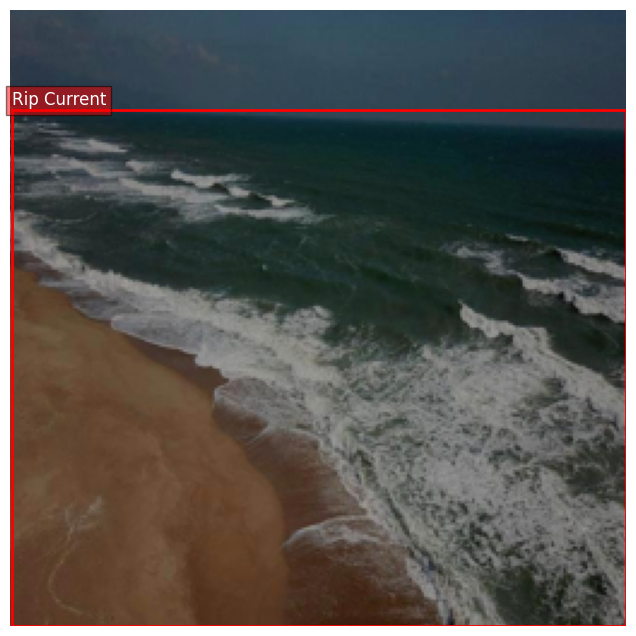

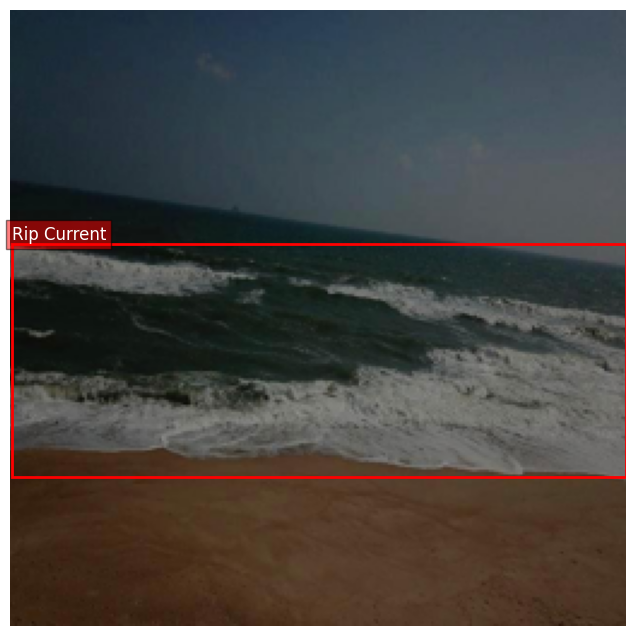

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
Training Epoch 2/10: 100%|██████████| 466/466 [04:54<00:00,  1.58it/s]


Average Training Loss: 2.361284588795363


Validation Epoch 2/10: 100%|██████████| 14/14 [00:03<00:00,  3.51it/s]


Average Validation Loss: 2.538734725543431


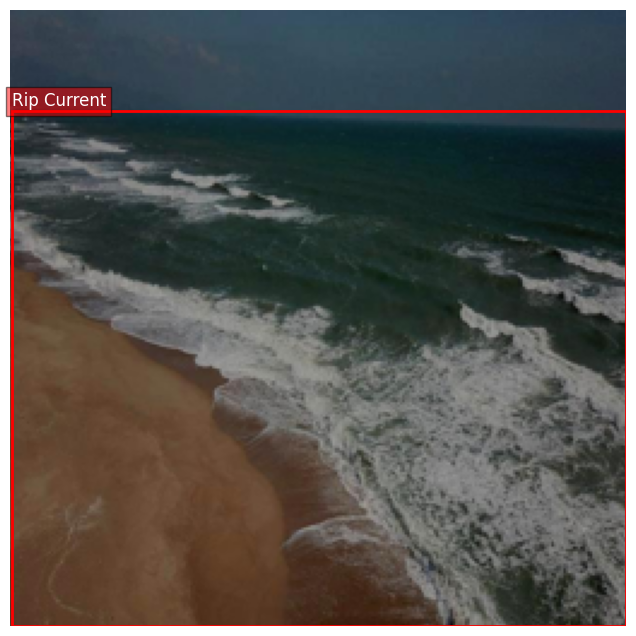

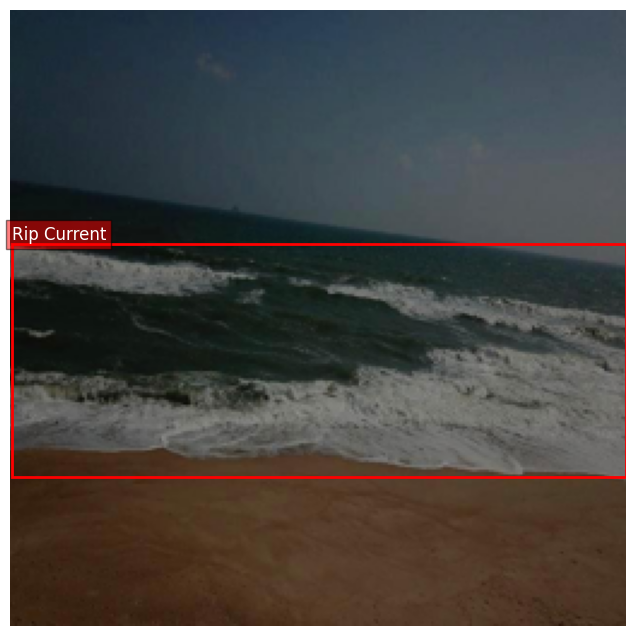

Training Epoch 3/10: 100%|██████████| 466/466 [04:55<00:00,  1.57it/s]


Average Training Loss: 2.1543393186233586


Validation Epoch 3/10: 100%|██████████| 14/14 [00:04<00:00,  3.05it/s]


Average Validation Loss: 2.4142507995877946


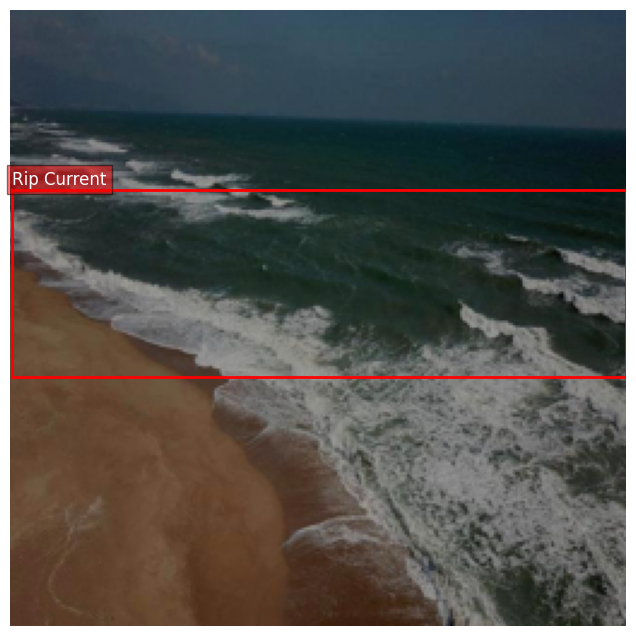

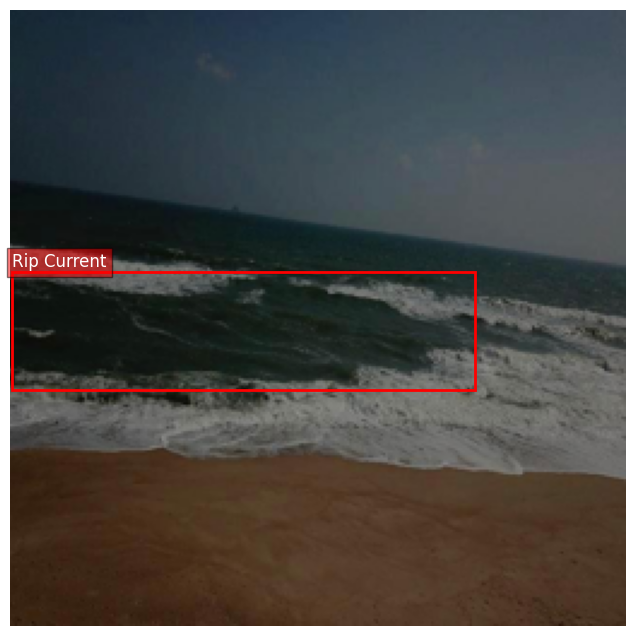

Training Epoch 4/10: 100%|██████████| 466/466 [05:29<00:00,  1.41it/s]


Average Training Loss: 2.0141173181615675


Validation Epoch 4/10: 100%|██████████| 14/14 [00:04<00:00,  3.44it/s]


Average Validation Loss: 2.386413778577532


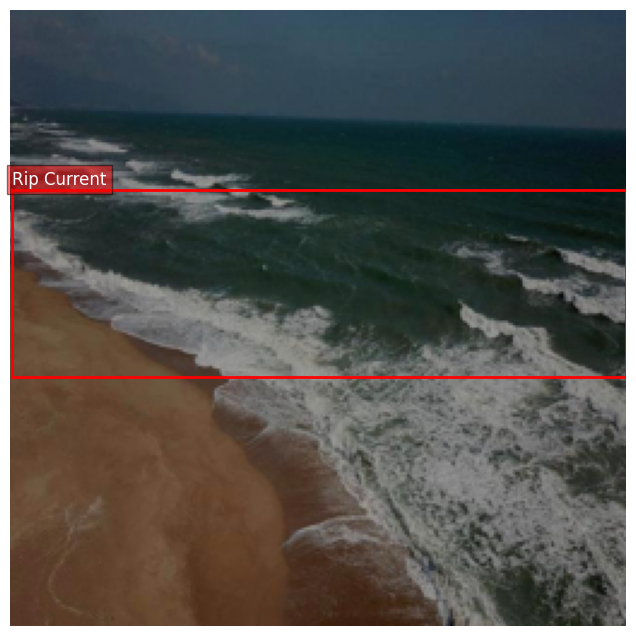

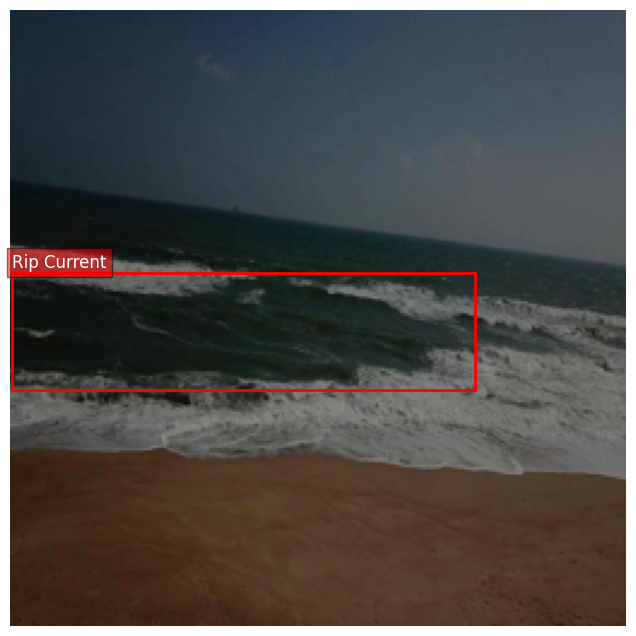

Training Epoch 5/10:  39%|███▉      | 184/466 [01:58<02:58,  1.58it/s]

In [ ]:
#  Training

EPOCHS = 10
LR = 4e-6
train_model(train_loader, val_loader, peft_model, processor, epochs=EPOCHS, lr=LR)